In [1]:
from itertools import combinations
from itertools import permutations
from sys import argv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
def Model1Horizontal(h, b, bays, floors, F1, LF):
    forces = np.ones(int(floors)) * F1 * LF
    forces[0] = F1/2 * LF
    columns = np.zeros(shape = (3, int(floors), int(bays+1)))
    beams = np.zeros(shape = (3, int(floors), int(bays)))
    adj = int(np.floor(bays/2))
    
    for i in range(int(floors)):    ## per floor
        Vc = np.zeros(int(bays+1))
        Nc = np.zeros(int(bays+1))
        Mc = np.zeros(int(bays+1))
    
        Vb = np.zeros(int(bays))
        Nb = np.zeros(int(bays))
        Mb = np.zeros(int(bays))
        
        if i == 0:
            N = forces[i] * h / b
            Nc[adj] = N
            Nc[adj+1] = N
        elif i ==1:
            M = forces[i] * h + forces[i-1] * (2*h)
            N = M / b
            Nc[adj] = N
            Nc[adj+1] = N
        else:
            M = forces[i] * h + forces[i-1] * (2*h) + forces[i-2] * (3*h)
            N = M / b
            Nc[adj] = N
            Nc[adj+1] = N
            
        columns[0][i] = Vc
        columns[1][i:] = Nc
        columns[2][i] = Mc
        
        beams[0][i] = Vb
        beams[1][i] = Nb
        beams[2][i] = Mb
    return(columns, beams)

def Model1Vertical(h, b, bays, floors, floorspan, LF, G, Qf, Qr, Gfact, Qfact, psiQf, psiQr, extreme):
    
    columns = np.zeros(shape = (3, int(floors), int(bays+1)))
    beams = np.zeros(shape = (3, int(floors), int(bays)))
    
    for i in range(int(floors)):
        if i == 0:
            q = (Gfact * G + Qfact * Qr * psiQr) * LF * floorspan
        else:
            q = (Gfact * G + Qfact * Qr * psiQf) * LF * floorspan
        
        if extreme == 1 and i == 0 and floors == 3:
            q = (1.2*G + 1.5*Qr*0) * LF * floorspan
        
        Vc = np.zeros(int(bays+1))
        Nc = np.ones(int(bays+1))
        Mc = np.zeros(int(bays+1))
    
        Vb = np.ones(int(bays))
        Nb = np.zeros(int(bays))
        Mb = np.ones(int(bays))
        
        Mb = Mb * (1/8) * q * b**2
        Nc = Nc * q * b
        Nc[0] = Nc[0] / 2
        Nc[-1] = Nc[-1] / 2
        
        Vb = Vb * ( ((1/8) * q * b**2 * 2) / (b/2) )
        
        columns[0][i] = Vc
        columns[1][i:] += Nc
        columns[2][i] = Mc
        
        beams[0][i] = Vb
        beams[1][i] = Nb
        beams[2][i] = Mb
    return(columns, beams)

In [3]:
def Model2Horizontal(h, b, bays, floors, F1, LF):
    forces = np.ones(int(floors)) * F1 * LF
    forces[0] = F1/2 * LF
    columns = np.zeros(shape = (3, int(floors), int(bays+1)))
    beams = np.zeros(shape = (3, int(floors), int(bays)))
    Force = 0
    for i in range(int(floors)):    ## per floor
        Vc = np.zeros(int(bays+1))
        Nc = np.zeros(int(bays+1))
        Mc = np.zeros(int(bays+1))
    
        Vb = np.zeros(int(bays))
        Nb = np.zeros(int(bays))
        Mb = np.zeros(int(bays))
        Force += forces[i]

        if i == 0:    ## First floor
            ## Shearforce in columns
            Vc = np.ones(int(bays+1)) * Force * (2 / (int(bays-1)*2 + 2* 1))
            Vc[0] /= 2
            Vc[-1] /= 2
            ## Moment in top of columns  
            Mc = Vc * h
            ## Normal force in beams
            Fres = forces[i]
            for j in range(int(bays)):
                Nb[j] = Fres - Vc[j]
                if j == int(bays - 1):
                    Vb[j] = Vb[j - 1]
                    Mb[j] = np.max( [Mc[-1], abs(Mc[-1] - b * Vb[j])] )
                elif j == 0:
                    Vb[j] = ((Fres - Nb[j]) * h ) / (b/2)
                    Mb[j] = np.max( [Mc[0], abs(Mc[0] - b*Vb[j])] )
                else:
                    Vb[j] = ((Fres - Nb[j]) * h - Vb[j-1] * (b/2)) / (b/2)
                    Mb[j] = np.max( [abs(Mb[j-1] - Mc[j]), abs(abs(Mb[j-1] - Mc[j]) - Vb[j] * h)] )
                Fres = Nb[j]
                
            ## Normalforce in columns
            for j in range(int(bays+1)):
                if j ==0:
                    Nc[j] = Vb[j]
                elif j == int(bays):
                    Nc[j] = Vb[-1]
                else:
                    Nc[j] = np.round(Vb[j-1] - Vb[j])
            
        else:
            Vc = np.ones(int(bays+1)) * Force * (2 / (int(bays-1)*2 + 2* 1))
            Vc[0] /= 2
            Vc[-1] /= 2
            Mc = Vc * h
            
            Fres = forces[i]
            for j in range(int(bays)):
                Nb[j] = columns[0][i-1][j] + Fres - Vc[j]
                
                if j == int(bays - 1):
                    Vb[j] = Vb[j - 1]
                    Mb[j] = np.max( [Mc[-1], abs(Mc[-1] - b * Vb[j])] )
                elif j == 0:
                    Vb[j] = ((columns[0][i-1][j] + Fres - Nb[j]) * h ) / (b/2)
                    Mb[j] = np.max( [Mc[0], abs(Mc[0] - b*Vb[j])] )
                else:
                    Vb[j] = ((columns[0][i-1][j] + Fres - Nb[j]) * h - Vb[j-1] * (b/2)) / (b/2)
                    Mb[j] = np.max( [abs(Mb[j-1] - Mc[j]), abs(abs(Mb[j-1] - Mc[j]) - Vb[j] * h)] )
                Fres = Nb[j]
                
            for j in range(int(bays+1)):
                if j ==0:
                    Nc[j] = Vb[0] + columns[1][i-1][j]
                elif j == int(bays):
                    Nc[j] = Vb[-1] + columns[1][i-1][j]
                else:
                    Nc[j] = Vb[j-1] - Vb[j] + columns[1][i-1][j]
                
        columns[0][i] = Vc
        columns[1][i] = Nc
        columns[2][i] = Mc
        
        beams[0][i] = Vb
        beams[1][i] = Nb
        beams[2][i] = Mb
        
    utot = (1/500) * floors * h * 10**3
    us = (1/300) * h * 10**3
    EI1 = 0
    EI2 = 0
    res = []
    for i in range(int(floors)):
        if i == int(floors-1):
            tot1 = ( ((beams[2][i][0]*10**6  * ((b*10**3)/2)) / 3) * (h*10**3) + (np.max(columns[0][i])*10**3 * (h*10**3)**3) / 3)
            tot2 = ( ((beams[2][i][0]*10**6  * ((b*10**3)/2)) / 3) * (h*10**3) + (np.min(columns[0][i])*10**3 * (h*10**3)**3) / 3)
            EI1 += tot1
            EI2 += tot2
            res.append(1/ (us / tot1) / 210e3 / 1e6)
            res.append(1/ (us / tot2) / 210e3 / 1e6)
            
        else: 
            tot1 = (((beams[2][i][0]*10**6 * ((b*10**3)/2)) / 3) * (h*10**3) + (np.max(columns[0][i])*10**3 * (h*10**3)**3) / 3)
            tot2 = (((beams[2][i][0]*10**6 * ((b*10**3)/2)) / 3) * (h*10**3) + (np.min(columns[0][i])*10**3 * (h*10**3)**3) / 3)
            EI1 += tot1
            EI2 += tot2
            res.append(1/ (us / tot1) / 210e3 / 1e6)
            res.append(1/ (us / tot2) / 210e3 / 1e6)
    res.append(1/ (utot / EI1) / 210e3 / 1e6)
    res.append(1/ (utot / EI2) / 210e3 / 1e6)
        
    return(columns, beams,res)   

def Model2Vertical(h, b, bays, floors, floorspan,LF, G, Qf, Qr, Gfact, Qfact, psiQf, psiQr, extreme):
    columns = np.zeros(shape = (3, int(floors), int(bays+1)))
    beams = np.zeros(shape = (3, int(floors), int(bays)))
    
    for i in range(int(floors)):    ## per floor
        if i == 0:
            q1 = (Gfact * G + Qfact * Qr * psiQr) * LF * floorspan
        else:
            q1 = (Gfact * G + Qfact * Qr * psiQf) * LF * floorspan
        
        if extreme == 1 and i == 0 and floors == 3:
            q1 = (1.2*G + 1.5*Qr*0) * LF * floorspan
            
        Vc = np.zeros(int(bays+1))
        Nc = np.zeros(int(bays+1))
        Mc = np.zeros(int(bays+1))
    
        Vb = np.zeros(int(bays))
        Nb = np.zeros(int(bays))
        Mb = np.zeros(int(bays))
    
        ql2 = (1/8) * q1 * b**2
        M = (0.8 * b * q1 / 2) * (0.1 * b) + (0.1 * b * q1) * (0.05 * b)
        ## Maximum moments beams
        Mb = np.ones(int(bays)) * M * 2
        
        ## Moments outer columns
        Mc[0] = M
        Mc[-1] = M
        ## Shearforce columns
        Vc = Mc/h
        
        ## Normalforce columns
        for j in range(int(bays+1)):
            if j == 0 or j == int(bays):
                M1 = Mc[0]
                M2 = M*2
                V = (abs(((M1 + M2) / 2 ) - 2 * ql2) + Mc[0]) / (b/2)
                Nc[j] = V
            else:
                V = (abs(M*2 - 2 * ql2) + 2*M) / (b/2)
                Nc[j] = 2 * V
        
        ## Maximum shearforce beams 
        Vb = (abs(M*2 - 2 * ql2) + 2*M) / (b/2)

        columns[0][i] = Vc
        columns[1][i:] += Nc
        columns[2][i] = Mc
        
        beams[0][i] = Vb
        beams[1][i] = Nb
        beams[2][i] = Mb
    return(columns,beams)

In [4]:
def Ilocal1(b, q):
    Ireq = (1/0.003) * ((5*q*(b*10**3)**3) / (384*210e3))
    return(Ireq/1e6)

def Ilocal2(b, q, kspanc):
    if kspanc == 1:
        Ireq = (1/0.003) * ((5*q*(b*10**3)**3) / (384*210e3))
    elif kspanc == 2:
        Ireq = (1/0.003) * ((q*(b*10**3)**3) / (110*102*210e3))
    elif kspanc == 3:
        Ireq = (1/0.003) * ((q*(b*10**3)**3) / (101*102*210e3)) 
    else:
        Ireq = (1/0.003) * ((q*(b*10**3)**3) / (102*102*210e3)) 
    return(Ireq/1e6)

def Nrd(minor, lbuc, I, A, fy):                       
    m = ["a", "b", "c", "d"]
    alphas = [0.21, 0.34, 0.49, 0.76]
    a = alphas[m.index(minor)]
    Ncr = (np.pi**2 * 210e3 * I) / (lbuc*10**3)**2
    lamb = np.sqrt((A * fy) / Ncr)
    n = a * (lamb - 0.2)
    g = 0.5 * (1 + n + lamb**2)
    chi = 1 / (g + np.sqrt(g**2 - lamb**2))
    return((chi * A * fy) / 1000)

In [5]:
def TheCode(Wmult, Useful, Designname, percreuse1, percreuse2):
    Wmult = float(Wmult)
    Useful = float(Useful)
    reusepercentage1 = float(percreuse1) / 100
    reusepercentage2 = float(percreuse2) / 100

    GHparams = pd.read_excel("GHuitvoer.xlsx", sheet_name = "inputarg")
    GHbeams = pd.read_excel("GHuitvoer.xlsx", sheet_name = "geometrybeams")
    GHcolumns = pd.read_excel("GHuitvoer.xlsx", sheet_name = "geometrycolumns")
    NewElems = pd.read_excel("NewElements.xlsx", skiprows = [1,2])
    
    hoh = float(GHparams.hohkolom)
    kspanc = float(GHparams["#kolomspans"])
    floors = float(GHparams["#verdiepingen"])
    floorheight = float(GHparams.verdiepingshoogte)
    fspanc = float(GHparams["#floorspans"])
    fspan = float(GHparams.floorspan)
    Gfloor = float(GHparams.Gfloor)
    
    if Gfloor == 1:
        if fspan == 3.6:
            G = 0.36 + 1.05
        elif fspan == 5.4:
            G = 0.39 + 1.05
        elif fspan ==7.2:
            G = 0.44 + 1.05
        else:
            G = 0.72 + 1.05
    elif Gfloor == 3:
        if fspan == 10.8:
            G = 3.83 + 1.8
        else:
            G = 2.83 + 1.8
    
    Q = 4 ## including light seperation walls
    
    hd = (floors * floorheight) / (hoh * kspanc)
    hps = [1,2,3,4,5,6,7,8,9,10,15,20]
    qps = [0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.73, 0.77, 0.81, 0.96, 1.07]
    qp = np.interp(floors * floorheight, hps, qps)
    
    if hd >= 5:
        Q_wind = qp * (1.0 + 0.7)
    elif hd < 5 and hd > 1:
        c_r = ((hd - 1) / 4) * 0.15 + 0.85
        Q_wind = qp * (0.8 * 0.5) * c_r
    else:
        Q_wind = qp * (0.7 + 0.3) * 0.85

    Fw = fspan * floorheight * Q_wind
    
    GHcolumns["N1"] = np.zeros(len(GHcolumns))
    GHbeams["V1"] = np.zeros(len(GHbeams))
    GHbeams["M1"] = np.zeros(len(GHbeams))
    GHbeams["I1"] = np.zeros(len(GHbeams))


    GHcolumns["N2"] = np.zeros(len(GHcolumns))
    GHcolumns["I2"] = np.zeros(len(GHcolumns))
    GHcolumns["V2"] = np.zeros(len(GHcolumns))
    GHbeams["V2"] = np.zeros(len(GHbeams))
    GHbeams["M2"] = np.zeros(len(GHbeams))
    GHbeams["I2"] = np.zeros(len(GHbeams))

    for i in range(int(fspanc+1)):

        if i == 0 or i == int(fspanc):
            factor = 0.5
        else: 
            factor = 1

        ##Model 1 analysis ULS
        # maxQ1beam = Model1Vertical(floorheight, hoh, kspanc, floors, (1.2*G + 1.5 * Q)*fspan, factor, 0, G, Q, fspan)[1]
        maxQ1beam = Model1Vertical(floorheight, hoh, kspanc, floors, fspan, factor, G, Q, 2, 1.2, 1.5, 1, 1, 0)[1]
        # maxG1beam = Model1Vertical(floorheight, hoh, kspanc, floors, (1.35*G + 1.5 * Q * 0.5)*fspan, factor, 0, G, Q, fspan)[1]
        maxG1beam = Model1Vertical(floorheight, hoh, kspanc, floors, fspan, factor, G, Q, 2, 1.35, 1.5, 0.5, 0, 0)[1]
        # wind1beam = Model1Horizontal(floorheight, hoh, kspanc, floors, 1.5*Fw, factor)[1] + Model1Vertical(floorheight, hoh, kspanc, floors, (1.2*G + 1.5 * Q * 0.5)*fspan, factor, 0, G, Q, fspan)[1]
        wind1beam = Model1Horizontal(floorheight, hoh, kspanc, floors, 1.5*Fw, factor)[1] + Model1Vertical(floorheight, hoh, kspanc, floors, fspan, factor, G, Q, 2, 1.2, 1.5, 0.5, 0, 0)[1]

        # maxG1col = Model1Vertical(floorheight, hoh, kspanc, floors, (1.35*G + 1.5 * Q * 0.5)*fspan, factor, 0, G, Q)[0]
        maxG1col = Model1Vertical(floorheight, hoh, kspanc, floors, fspan, factor, G, Q, 2, 1.35, 1.5, 0.5, 0, 0)[0]
        # extremeQ1col = Model1Vertical(floorheight, hoh, kspanc, floors, (1.2*G + 1.5*Q*1)*fspan, factor, 1, G, Q)[0]
        extremeQ1col = Model1Vertical(floorheight, hoh, kspanc, floors, fspan, factor, G, Q, 2, 1.2, 1.5, 1, 1, 1)[0]
        # wind1col = Model1Horizontal(floorheight, hoh, kspanc, floors, 1.5*Fw, factor)[1] + Model1Vertical(floorheight, hoh, kspanc, floors, (1.2*G + 1.5 * Q * 0.5)*fspan, factor, 0, G, Q)[1]
        wind1col = Model1Horizontal(floorheight, hoh, kspanc, floors, 1.5*Fw, factor)[1] + Model1Vertical(floorheight, hoh, kspanc, floors, fspan, factor, G, Q, 2, 1.2, 1.5,0.5,0,0)[1]
        
        ##Model 2 analysis ULS
        maxQ2beam = Model2Vertical(floorheight, hoh, kspanc, floors, fspan, factor, G, Q, 2, 1.2, 1.5, 1, 1, 0)[1]
        maxG2beam = Model2Vertical(floorheight, hoh, kspanc, floors, fspan, factor, G, Q, 2, 1.35, 1.5, 0.5, 0, 0)[1]
        wind2beam = Model2Horizontal(floorheight, hoh, kspanc, floors, 1.5*Fw, factor)[1] + Model2Vertical(floorheight, hoh, kspanc, floors, fspan, factor, G, Q, 2, 1.2, 1.5, 0.5, 0, 0)[1]

        maxG2col = Model2Vertical(floorheight, hoh, kspanc, floors, fspan, factor, G, Q, 2, 1.35, 1.5, 0.5, 0, 0)[0]
        extremeQ2col = Model2Vertical(floorheight, hoh, kspanc, floors, fspan, factor, G, Q, 2, 1.2, 1.5, 1, 1, 1)[0]
        wind2col = Model2Horizontal(floorheight, hoh, kspanc, floors, 1.5*Fw, factor)[0] + Model2Vertical(floorheight, hoh, kspanc, floors, fspan, factor, G, Q, 2, 1.2, 1.5, 1, 1, 1)[0]

        ## Model 2 analysis global deformation (SLS combination)
        EIreq = Model2Horizontal(floorheight, hoh, kspanc, floors, Fw, factor)[2]
        
        for j in range(int(floors)):
            ##Model 1 assignment
            for x in range(int(kspanc+1)):
                GHcolumns.N1.iloc[int(i * (kspanc+1) * floors + j * (kspanc+1)) + x] = np.max([maxG1col[1][int(floors)-(j+1)][x], wind2col[1][int(floors)-(j+1)][x], extremeQ2col[1][int(floors)-(j+1)][x]])
            for x in range(int(kspanc)):
                GHbeams.V1.iloc[int(i * (kspanc) * floors + j * (kspanc)) + x] = np.max([maxQ1beam[0][int(floors)-(j+1)][x], maxG1beam[0][int(floors)-(j+1)][x], wind1beam[0][int(floors)-(j+1)][x]])
                GHbeams.M1.iloc[int(i * (kspanc) * floors + j * (kspanc)) + x] = np.max([maxQ1beam[2][int(floors)-(j+1)][x], maxG1beam[2][int(floors)-(j+1)][x], wind1beam[2][int(floors)-(j+1)][x]])
                GHbeams.I1.iloc[int(i * (kspanc) * floors + j * (kspanc)) + x] = Ilocal1(hoh, 1*G + 1*Q)

            ## Model 2 assignment
            for x in range(int(kspanc+1)):
                GHcolumns.N2.iloc[int(i * (kspanc+1) * floors + j * (kspanc+1)) + x] = np.max([maxG2col[1][int(floors)-(j+1)][x], wind2col[1][int(floors)-(j+1)][x], extremeQ2col[1][int(floors)-(j+1)][x]])
                GHcolumns.V2.iloc[int(i * (kspanc+1) * floors + j * (kspanc+1)) + x] = np.max([maxG2col[0][int(floors)-(j+1)][x], wind2col[0][int(floors)-(j+1)][x], extremeQ2col[0][int(floors)-(j+1)][x]])
                if x == 0 or x == int(kspanc):
                    GHcolumns.I2.iloc[int(i * (kspanc+1) * floors + j * (kspanc+1)) + x] = np.max([EIreq[j*2 + 1], EIreq[-1]])
                else:
                    GHcolumns.I2.iloc[int(i * (kspanc+1) * floors + j * (kspanc+1)) + x] = np.max([EIreq[j*2], EIreq[-2]])

            for x in range(int(kspanc)):
                GHbeams.V2.iloc[int(i * (kspanc) * floors + j * (kspanc)) + x] = np.max([maxQ2beam[0][int(floors)-(j+1)][x], maxG2beam[0][int(floors)-(j+1)][x], wind2beam[0][int(floors)-(j+1)][x]])
                GHbeams.M2.iloc[int(i * (kspanc) * floors + j * (kspanc)) + x] = np.max([maxQ2beam[2][int(floors)-(j+1)][x], maxG2beam[2][int(floors)-(j+1)][x], wind2beam[2][int(floors)-(j+1)][x]])
                GHbeams.I2.iloc[int(i * (kspanc) * floors + j * (kspanc)) + x] = np.max([Ilocal2(hoh, 1*G+1*Q, kspanc), EIreq[j], EIreq[-1]])
    
    ## Initial sway-imperfections and second-order effects
    theta0 = 1/200                              ## Initial sway-imperfection for steel columns
    am = np.sqrt(0.5 * (1 + 1/kspanc + 1))      ## Reduction factor for contributing columns 
    ah = 2 / np.sqrt(floors * floorheight)      ## Reduction factor for building height
    theta = theta0 * ah * am + (1/300)          ## Total rotation of each column: initial sway imperfection and displacement due windloading.
    N = np.array(GHcolumns.N2)                 
    V = np.array(GHcolumns.V2)
    H = N * theta                               ## Equivalent horizontal forces due to total displacement of the column
    factor = (H/V + 1)                          ## Moment factor (initial sway imperfections + second order effect) per column

    for i in range(int(fspanc+1)):              
        for j in range(int(floors)): 
            n = factor[j * int(kspanc+1) + i * int(floors)*int(kspanc)]        ## Determine second-order+initial sway imp factor per storey. 
            GHbeams.M2.iloc[j*int(kspanc) + i * int(floors)*int(kspanc):(j+1)*int(kspanc) + i * int(floors)*int(kspanc)] *= n    ## Multiply bending moments accordingly per storey
    
    
    NewElems["Nrd1"] = np.zeros(len(NewElems))
    NewElems["Nrd2"] = np.zeros(len(NewElems))
    for i in range(len(NewElems)):
        NewElems["Nrd1"].iloc[i] =  Nrd(NewElems["Buckling about minor axis z-z"].iloc[i], floorheight*1.0, NewElems["Second moment of area z"].iloc[i] * 10**6, NewElems.Area.iloc[i], 355);
        NewElems["Nrd2"].iloc[i] =  Nrd(NewElems["Buckling about minor axis z-z"].iloc[i], floorheight*0.7, NewElems["Second moment of area z"].iloc[i] * 10**6, NewElems.Area.iloc[i], 355);
        NewElems["MrdN"] = NewElems["Plastic section modulus"] * 355 /1000

    GHcolumns["NCS1"] = np.zeros(len(GHcolumns))
    GHcolumns["NG1"] = np.zeros(len(GHcolumns))
    GHbeams["NCS1"] = np.zeros(len(GHbeams))
    GHbeams["NG1"] = np.zeros(len(GHbeams))

    GHcolumns["NCS2"] = np.zeros(len(GHcolumns))
    GHcolumns["NG2"] = np.zeros(len(GHcolumns))
    GHbeams["NCS2"] = np.zeros(len(GHbeams))
    GHbeams["NG2"] = np.zeros(len(GHbeams))

    for f in range(int(fspanc+1)):
        model1G = []
        model1I = []
        model2G = []
        model2I = []
        for i in range(int(kspanc+1)):
            Nlead2 = (NewElems[18:42].Profile.loc[NewElems.Nrd2 > GHcolumns.N2.iloc[f*int( (kspanc+1) * floors) + i]].tolist()[0])
            Ilead2 = (NewElems[18:42].Profile.loc[NewElems["Second moment of area y"] > GHcolumns.I2.iloc[f*int( (kspanc+1) * floors) + i]].tolist()[0])

            model1I.append(NewElems[18:42].Profile.loc[NewElems.Nrd1 > GHcolumns.N1.iloc[f*int( (kspanc+1) * floors) + i]].tolist()[0])
            model1G.append(NewElems[18:42].Weight.loc[NewElems.Nrd1 > GHcolumns.N1.iloc[f*int( (kspanc+1) * floors) + i]].tolist()[0])

            if int(Nlead2[-3:]) > int(Ilead2[-3:]): 
                model2I.append(Nlead2)
                model2G.append(NewElems[18:42].Weight.loc[NewElems.Nrd2 > GHcolumns.N2.iloc[f*int( (kspanc+1) * floors) + i]].tolist()[0])
            else:
                model2I.append(Ilead2)
                model2G.append(NewElems[18:42].Weight.loc[NewElems["Second moment of area y"] > GHcolumns.I2.iloc[f*int( (kspanc+1) * floors) + i]].tolist()[0])


        for i in range(int(floors)):
            GHcolumns.NCS1.iloc[int(f*(kspanc+1)*floors + i * (kspanc+1)):int(f*(kspanc+1)*floors + (i+1) * (kspanc+1))] = model1I
            GHcolumns.NG1.iloc[int(f*(kspanc+1)*floors + i * (kspanc+1)):int(f*(kspanc+1)*floors + (i+1) * (kspanc+1))] = model1G
            GHcolumns.NCS2.iloc[int(f*(kspanc+1)*floors + i * (kspanc+1)):int(f*(kspanc+1)*floors + (i+1) * (kspanc+1))] = model2I
            GHcolumns.NG2.iloc[int(f*(kspanc+1)*floors + i * (kspanc+1)):int(f*(kspanc+1)*floors + (i+1) * (kspanc+1))] = model2G

        model2G = []
        model2I = []
        model1G = []
        model1I = []

        for i in range(int(kspanc)):
            Ilead1 = (NewElems.Profile.loc[NewElems["Second moment of area y"] > GHbeams.I1.iloc[f*int(kspanc * floors)+1]].tolist()[0])
            Mlead1 = (NewElems.Profile.loc[NewElems.MrdN > GHbeams.M1.iloc[f*int(kspanc * floors)+1]].tolist()[0])
            Ilead2 = (NewElems.Profile.loc[NewElems["Second moment of area y"] > GHbeams.I2.iloc[f*int(kspanc * floors)+1]].tolist()[0])
            Mlead2 = (NewElems.Profile.loc[NewElems.MrdN > GHbeams.M2.iloc[f*int(kspanc * floors)+1]].tolist()[0])

            if int(Mlead2[-3:]) > int(Ilead2[-3:]): 
                model2I.append(Mlead2)
                model2G.append(NewElems.Weight.loc[NewElems.MrdN > GHbeams.M2.iloc[f*int(kspanc * floors)+1]].tolist()[0])
            else:
                model2I.append(Ilead2)
                model2G.append(NewElems.Weight.loc[NewElems["Second moment of area y"] > GHbeams.I2.iloc[f*int(kspanc * floors)+1]].tolist()[0])

            if int(Mlead1[-3:]) > int(Ilead1[-3:]): 
                model1I.append(Mlead1)
                model1G.append(NewElems.Weight.loc[NewElems.MrdN > GHbeams.M1.iloc[f*int(kspanc * floors)+1]].tolist()[0])
            else:
                model1I.append(Ilead1)
                model1G.append(NewElems.Weight.loc[NewElems["Second moment of area y"] > GHbeams.I1.iloc[f*int(kspanc * floors)+1]].tolist()[0])

        for i in range(int(floors)):
            GHbeams.NCS1.iloc[int(f*(kspanc)*floors + i * (kspanc)):int(f*(kspanc)*floors + (i+1) * (kspanc))] = model1I
            GHbeams.NG1.iloc[int(f*(kspanc)*floors + i * (kspanc)):int(f*(kspanc)*floors + (i+1) * (kspanc))] = model1G
            GHbeams.NCS2.iloc[int(f*(kspanc)*floors + i * (kspanc)):int(f*(kspanc)*floors + (i+1) * (kspanc))] = model2I
            GHbeams.NG2.iloc[int(f*(kspanc)*floors + i * (kspanc)):int(f*(kspanc)*floors + (i+1) * (kspanc))] = model2G  
    
    print("Dimensioning done")
    
    ddata = pd.read_excel('Database.xlsx')
    ddata['Mcap'] = (ddata.W * ddata.Fy) / 1000       ## Calculate the moment-capacity for all donor elements
    ddata['Npl'] = np.zeros(len(ddata))
    ddata['Nrd1'] = np.zeros(len(ddata))
    ddata['Nrd2'] = np.zeros(len(ddata))          ## Calculate normal-force capacity for all donor elements
    for i in range(len(ddata)):
        ddata.Npl.iloc[i] = ddata.A.iloc[i] * ddata.Fy.iloc[i] / 1000
        ddata.Nrd1.iloc[i] = Nrd(ddata["bucmin"].iloc[i], floorheight*1, ddata.Iz.iloc[i] * 10**6, ddata.A.iloc[i], ddata.Fy.iloc[i]);
        ddata.Nrd2.iloc[i] = Nrd(ddata["bucmin"].iloc[i], floorheight*0.7, ddata.Iz.iloc[i] * 10**6, ddata.A.iloc[i], ddata.Fy.iloc[i]);

    
    ## Assignment model 1 columns (continuous) --> Challenge!
    ids = list(ddata.index)
    lengths = list(ddata.Length)
    G = list(ddata.G)
    Wd = list(ddata.Nrd1)
    target = floors * floorheight
    ids1 = ddata.index[ddata.Nrd1 > GHcolumns.N1.min()].tolist()
    ids2 = ddata.index[ddata.Length > 0.5 * floorheight].tolist()

    idschecked = np.intersect1d(ids1, ids2)
    lengthperms = []
    fits = []
    fit = []
    strength = []
    MaxG = NewElems[18:42].Weight.loc[NewElems.Nrd1 > GHcolumns.N1.max()].tolist()[0]
    for i in range(int(floors)):
        perms = list(combinations(idschecked, i+1))    ## Create all permutations for i amount of elements in one columns
        lengthperms.append(len(perms))                 ## Keep track of amount of options per i
        for perm in range(len(perms)):                 ## Loop through all permutations
            lres = target
            W = 0
            s = []

            for p in perms[perm]:                      ## Loop through parts of permutation
                l = lengths[p]                         ## Length of part
                Gd = G[p]
                if lres - l > 0:                       ## If resultant length > 0: save weight and strength
                    lres -= l
                    W += Gd * l
                    s.append(Wd[p])

                else:                                  ## If resultant length < 0 ..
                    if lres - l < 0 and p != perms[perm][-1]: ## .. and not the last piece --> perm not possible
                        break

                    elif lres - l > Useful:            ## .. and bigger than Useful rest length --> possible calc weight with required length
                        W += Gd * lres
                        s.append(Wd[p])
                    else:                              ## .. and smaller than Useful rest length --> possible calc weight with part length
                        W += Gd * l
                        s.append(Wd[p])

                    if W < MaxG * floorheight * Wmult * floors:   ## If total weight is smaller than limit save perm information
                        fits.append(perms[perm])
                        fit.append(W)
                        strength.append(np.min(s))
    
    colsf = int(kspanc + 1) * int(floors)
    ass1 = np.zeros(len(ddata))
    W1req = 0
    W1new = 0
    Waste1 = 0
    assC1 = np.zeros( (int(fspanc+1) * int(kspanc+1), len(ddata)) )
    fitass = fit

    for frame in range(int(fspanc+1)):                            ## Loop through each frame

        for col in range(int(kspanc+1)):                          ## Loop through each frame's columns
            Weis = GHcolumns.N1.iloc[frame * colsf + col]         ## Determine minimum N
            for j in range(len(fitass)):                          ## Loop through all possible combinations
                if np.nansum(fitass) <= 0:
                    break
                else:
                    bestfit = np.nanargmin(fitass)                    ## Find best fit
                    Wbestfit = fitass[bestfit]                        ## Determine weight best fit
                    Sbestfit = strength[bestfit]                      ## Determine strength best fit

                    if np.nansum(fitass) <= 0:
                        break                                            ## Loop through all possible combinations

                    if Weis <= Sbestfit:
                        asscheck = 0
                        for d in fits[bestfit]:
                            asscheck += ass1[d]

                        if asscheck == 0:                             ## If yes --> assign element in assignment matrix
                            lreq = floors * floorheight
                            W1req += fitass[bestfit]

                            for d in fits[bestfit]: 
                                l = ddata.Length.iloc[d]              ## Get length
                                ass1[d] = 1                            ## Set to assigned                       
                                fitass[bestfit] = np.nan                 ## Delete fit for future selection
                                if lreq - l >= 0:                     ## Set length to length of elements if total length is not reached
                                    assC1[frame * int(kspanc+1) + col, d] = l   
                                else:                                 ## Set length to rest length if total length is reached
                                    assC1[frame * int(kspanc+1) + col, d] = lreq
                                    lengths[d] = l - lreq
                                lreq -= l                             ## Update rest length
                            break                                     ## If assigned stop look for this column
                        else:
                            fitass[bestfit] = np.nan  
                    else:
                        fitass[bestfit] = np.nan                     ## If element(s) are not available, set fit to zero for future selection
    
    ## Assignment model 1 beams (simply supported) --> 'Simple' Assignment Matrix
    FitB1 = np.zeros((len(GHbeams), len(ddata)))

    for i in range(len(GHbeams)):
        Gn = GHbeams.NG1.iloc[i]
        bl = GHbeams.Length.iloc[i]

        for j in range(len(ddata)):
            dl = lengths[j]
            Mcap = ddata.Mcap.iloc[j]
            Iyd = ddata.Iy.iloc[j]
            Mmin1 = GHbeams.M1.iloc[i]
            Imin1 = GHbeams.I1.iloc[i]
            if Mcap >= Mmin1 and Iyd >= Imin1 and dl >= bl:
                Gd = ddata.G.iloc[j]

                if dl - bl >= Useful:
                    FitB1[i,j] = 1 - ((Gd * bl - Gn * bl) / ((Wmult-1)* Gn * bl))
                else:
                    FitB1[i,j] = 1 - ((Gd * dl - Gn * bl) / ((Wmult-1)* Gn * bl))

    FitB1[FitB1<0] = 0
    assB1 = np.zeros( (len(GHbeams), len(ddata)) )
    count = 0
    for i in range(len(GHbeams) * len(ddata)):
        if np.sum(FitB1) > 0:
            bestfit = np.max(FitB1)
            bestfitid = np.argmax(FitB1)
            row = int(np.trunc(bestfitid / len(ddata)))
            col = int(bestfitid - row * len(ddata))
            dl = lengths[col]
            lreq = GHbeams.Length.iloc[row]
            if dl >= lreq:
                assB1[row,col] = 1
                if dl - lreq >= Useful:
                    lengths[col] = dl - lreq
                else:
                    lengths[col] = 0
                    Waste1 += ddata.G.iloc[col] * (dl - lreq)
                W1req += ddata.G.iloc[col] * (lreq)
                count+=1
                FitB1[row] = 0
            else:
                FitB1[row,col] = 0

    for i in range(len(GHbeams)):
        if np.sum(assB1[i]) == 0:
            W1new += GHbeams.NG1.iloc[i] * GHbeams.Length.iloc[i]
            # Ilead = (NewElems.Profile.loc[NewElems["Second moment of area y"] > GHbeams.I1.iloc[i]].tolist()[0])
            # Nlead = (NewElems.Profile.loc[NewElems.MrdN > GHbeams.M1.iloc[i]].tolist()[0])
            # if int(Nlead[-3:]) > int(Ilead[-3:]): 
            #     W1new += NewElems.Weight.loc[NewElems.MrdN > GHbeams.M1.iloc[i]].tolist()[0] *  GHbeams.Length.iloc[i]
            # else:
            #     W1new += NewElems.Weight.loc[NewElems["Second moment of area y"] > GHbeams.I1.iloc[i]].tolist()[0] * GHbeams.Length.iloc[i]
    count = 0
    c = np.arange(kspanc+1, (kspanc+1)*(fspanc+1), kspanc+1)
    for i in range(len(assC1)):
        if np.count_nonzero(c==i):
                count += 1
        if np.sum(assC1[i]) == 0:
            W1new += GHcolumns.NG1.iloc[i + count * int(kspanc+1) * int(floors-1)] * floors * floorheight
    
    print("Model 1 complete")
    
    ids = list(ddata.index)
    lengths = list(ddata.Length)
    G = list(ddata.G)
    Id = list(ddata.Iy)
    Wd = list(ddata.Mcap)
    target = kspanc * hoh
    ids1 = ddata.index[ddata.Mcap > GHbeams.M2.min()].tolist()
    ids2 = ddata.index[ddata.Length > 0.5 * hoh].tolist()

    idschecked = np.intersect1d(ids1, ids2)
    lengthperms = []
    fits = []
    fit = []
    strength = []
    Is = []
    ls = []

    lsfl = np.arange(hoh * (3/4), hoh * kspanc - hoh/2, 1/2 * hoh)
    lsm = np.arange(0.5 * hoh, 1.5 * hoh, 0.5 * hoh)
    for i in range(int(kspanc)):
        print(f"starting perms 1/{kspanc}")
        perms = list(permutations(idschecked, i+1))    ## Create all permutations for i amount of elements in one columns
        lengthperms.append(len(perms))                 ## Keep track of amount of options per i

        for perm in range(len(perms)):                 ## Loop through all permutations
            lreq = target
            lt = 0
            l = []
            I = []
            W = 0
            s = []

            for p in perms[perm]:                      ## Loop through parts of permutation
                lt += lengths[p]                       ## Length of part
            if lt >= lreq:
                for p in perms[perm]:

                    if lreq - lengths[p] < 0 and p != perms[perm][-1]:
                        break

                    elif p == perms[perm][-1]:
                        if lreq - lengths[p] > 0:
                            break
                        else:
                            l.append(np.round(lreq, 2))
                            W += G[p] * lreq
                            s.append(Wd[p])
                            I.append(Id[p])
                            if W < GHbeams.NG2.max()* GHbeams.Length.max() * kspanc * Wmult:
                                fit.append(W)
                                ls.append(l)
                                fits.append(perms[perm])
                                strength.append(np.min(s))
                                Is.append(np.min(I))

                    elif p == perms[perm][0]:
                        ltred = lsfl - lengths[p]
                        if ltred[0] < 0:
                            ltb = np.max(ltred[ltred<0]) + lengths[p]
                            l.append(np.round(ltb,2))
                            lreq -= ltb
                            W += G[p] * ltb
                            s.append(Wd[p])
                            I.append(Id[p])
                        else:
                            break

                    else:
                        ltred = lsm - lengths[p]
                        ltb = np.max(ltred[ltred<0]) + lengths[p]
                        l.append(np.round(ltb,2))
                        lreq -= ltb
                        W += G[p] * ltb 
                        s.append(Wd[p])
                        I.append(Id[p])
    
    bpf = kspanc * floors
    ass2 = np.zeros(len(ddata))
    assB2 = np.zeros( (int(floors * (fspanc+1)), len(ddata)) )
    W2req = 0
    W2new = 0
    Waste2 = 0
    fitass = fit
    for frame in range(int(fspanc+1)):
        print(f"Starting assignment frame 1/{fspanc+1}")
        for beam in range(int(floors)):
            Weis = GHbeams.M2.iloc[int(frame * bpf + beam*kspanc):int(frame*bpf + (1+beam)*kspanc)].max()
            Ieis = GHbeams.I2.iloc[int(frame * bpf + beam*kspanc):int(frame*bpf + (1+beam)*kspanc)].max()

            for j in range(len(fitass)):
                if np.nansum(fitass) <= 0:
                    break                                            ## Loop through all possible combinations

                else:
                    bestfit = np.nanargmin(fitass) ## Find best fit
                    if bestfit == np.nan:
                        break
                    Wbestfit = fitass[bestfit]                           ## Determine weight best fit
                    Sbestfit = strength[bestfit] ## Determine strength best fit
                    Ibestfit = Is[bestfit]

                    if Weis <= Sbestfit and Ieis <= Ibestfit:
                        asscheck = 0
                        l = ls[bestfit] ## Get length
                        for d in fits[bestfit]:                       ## Check if elements are still available
                            asscheck += ass2[d]
                        if asscheck == 0:                             ## If yes --> assign element in assignment matrix
                            lreq = hoh * kspanc
                            W2req += fitass[bestfit]
                            ids = fits[bestfit]

                            for d in range(len(fits[bestfit])): 
                                ass2[ids[d]] = 1                           ## Set to assigned                       
                                fitass[bestfit] = np.nan                 ## Delete fit for future selection
                                if lreq - l[d] >= 0:                     ## Set length to length of elements if total length is not reached
                                    assB2[int(frame * floors + beam), ids[d]] = l[d]
                                    W2req += l[d] * G[ids[d]]
                                else:                                 ## Set length to rest length if total length is reached
                                    assB2[int(frame * floors + beam), ids[d]] = lreq
                                    W2req+= lreq * G[ids[d]]
                                lengths[ids[d]] = lreq - l[d]
                                lreq -= l[d]                             ## Update rest length
                            break                                     ## If assigned stop look for this column

                        else:
                            fitass[bestfit] = np.nan
                    else:
                        fitass[bestfit] = np.nan
    
    print("Continuous beams model 2 done --> 1/2")
    
    ## Assignment model 2 columns --> 'Simple' Assignment Matrix
    FitC2 = np.zeros((len(GHcolumns), len(ddata)))

    for i in range(len(GHcolumns)):
        Gn = GHcolumns.NG2.iloc[i]
        bl = GHcolumns.Length.iloc[i]
        Nmin2 = GHcolumns.N2.iloc[i]
        Imin2 = GHcolumns.I2.iloc[i]
        for j in range(len(ddata)):
            dl = ddata.Length.iloc[j]
            Iyd = ddata.Iy.iloc[j]
            Nrd2 = ddata.Nrd2.iloc[j]
            if Iyd >= Imin2 and Nrd2 >= Nmin2 and dl >= bl:
                Gd = ddata.G.iloc[j]

                if dl - bl >= Useful:
                    FitC2[i,j] = 1 - ((Gd * bl - Gn * bl) / ((Wmult-1)* Gn * bl))
                else:
                    FitC2[i,j] = 1 - ((Gd * dl - Gn * bl) / ((Wmult-1)* Gn * bl))

    FitC2[FitC2<0] = 0
    assC2 = np.zeros( (len(GHcolumns), len(ddata)) )
    count = 0
    for i in range(len(GHcolumns) * len(ddata)):
        if np.sum(FitC2) > 0:
            bestfit = np.max(FitC2)
            bestfitid = np.argmax(FitC2)
            row = int(np.trunc(bestfitid / len(ddata)))
            col = int(bestfitid - row * len(ddata))
            dl = lengths[col]
            lreq = GHcolumns.Length.iloc[row]
            if dl >= lreq:
                assC2[row,col] = 1
                if dl - lreq >= Useful:
                    lengths[col] = dl - lreq
                else:
                    lengths[col] = 0
                    Waste2 += ddata.G.iloc[col] * (dl - lreq)
                W2req += ddata.G.iloc[col] * (lreq)
                count+=1
                FitC2[row] = 0
            else:
                FitC2[row,col] = 0
        else: 
            break

    for i in range(len(GHcolumns)):
        if np.sum(assC2[i]) == 0:
            W2new += GHcolumns.NG2.iloc[i] * GHcolumns.Length.iloc[i]

    for i in range(int(len(GHbeams)/kspanc)):
        if np.sum(assB2[i]) == 0:
            W2new += GHbeams.NG2.iloc[int(i*kspanc)] * kspanc * hoh
    
    print("Model 2 complete")
    
    
    # Assignment of beams model 1
    H000200 = []
    H200400 = []
    H400600 = []
    H6001000 = []
    labelz = ["h = 0-200mm", "h = 200-400 mm", "h = 400-600 mm", "h = 600-1000 mm"]
    
    B1 = []
    D = []
    G = []
    for i in range(len(GHbeams)):
        if np.sum(assB1[i]) > 0:
            ids = np.argwhere(assB1[i]>0)
            B1.append(ddata["Cross-section"].iloc[ids[0]].values[0])
            G.append(ddata.G.iloc[ids[0]].values[0])
            D.append("yes")
            
            h = ddata.h.iloc[ids[0][0]]
            l = ddata.Length.iloc[ids[0][0]]
            if h <= 200:
                H000200.append(l)
            elif h > 200 and h <= 400:
                H200400.append(l)
            elif h > 400 and h <= 600:
                H400600.append(l)
            else:
                H6001000.append(l)

        else:
            Ilead = (NewElems.Profile.loc[NewElems["Second moment of area y"] > GHbeams.I1.iloc[i]].tolist()[0])
            Nlead = (NewElems.Profile.loc[NewElems.MrdN > GHbeams.M1.iloc[i]].tolist()[0])
            if int(Nlead[-3:]) > int(Ilead[-3:]): 
                B1.append(Nlead)
            else:
                B1.append(Ilead)
            G.append("nvt")
            D.append("no")
    GHbeams["RCS1"] = B1
    GHbeams["DG1"] = G
    GHbeams["donor"] = D

    # Assignment of columns model 1
    C1 = []
    L = []
    D = []
    
    c = np.arange(kspanc+1, (kspanc+1)*(fspanc+1), kspanc+1)
    count = 0
    
    for i in range(len(assC1)):
        k = []
        l = []
        
        if np.count_nonzero(c==i):
            count += 1
        
        if np.sum(assC1[i]) > 0:
            ids = np.argwhere(assC1[i] > 0)
            for j in ids:
                k.append(ddata["Cross-section"].iloc[j].values[0])
                l.append(assC1[i][j][0])
                
                h = ddata.h.iloc[j[0]]
                lg = ddata.Length.iloc[j[0]]
                if h <= 200:
                    H000200.append(lg)
                elif h > 200 and h <= 400:
                    H200400.append(lg)
                elif h > 400 and h <= 600:
                    H400600.append(lg)
                else:
                    H6001000.append(lg)
                
            C1.append(k)
            L.append(l)
            D.append("yes")
        else:
            C1.append([NewElems[18:42].Profile.loc[NewElems.Nrd1 > GHcolumns.N1.iloc[i + count * int(kspanc+1) * int(floors-1)]].tolist()[0]])
            D.append("no")
            L.append([floors * floorheight])

    CD1 = pd.DataFrame(C1)
    CL1 = pd.DataFrame(L)
    arr = [H000200, H200400, H400600, H6001000]

    plt.figure(figsize = (12,5))
    plt.hist(arr, label = labelz, bins = np.arange(0, 16,1))
    plt.grid()
    plt.xticks(np.arange(0, 16,1))
    plt.legend()
    plt.title("Availability of structural elements of a certain structural height and length")
    plt.ylabel(f"Occurance in dataset (#)")
    plt.xlabel(f"Element length (bins) --> e.g. 1 to 2 meters")
    plt.savefig(f"DonorUse1.png", bbox_inches = 'tight')

    # Assignment of beams model 2
    H000200 = []
    H200400 = []
    H400600 = []
    H6001000 = []
    labelz = ["h = 0-200mm", "h = 200-400 mm", "h = 400-600 mm", "h = 600-1000 mm"]
    
    B2 = []
    G = []
    D = []
    L = []
    
    for i in range(len(assB2)):
        k = []
        l = []
        
        if np.sum(assB2[i]) > 0:
            ids = np.argwhere(assB2[i] > 0)
            for j in ids:
                k.append(ddata["Cross-section"].iloc[j].values[0])
                l.append(assB2[i][j][0])
                
                h = ddata.h.iloc[j[0]]
                lg = ddata.Length.iloc[j[0]]
                if h <= 200:
                    H000200.append(lg)
                elif h > 200 and h <= 400:
                    H200400.append(lg)
                elif h > 400 and h <= 600:
                    H400600.append(lg)
                else:
                    H6001000.append(lg)
                    
            B2.append(k)
            L.append(l)
            D.append("yes")
        else:
            B2.append([GHbeams.NCS2.iloc[int(i*kspanc)]])
            D.append("no")
            L.append([kspanc*hoh])
    BD2 = pd.DataFrame(B2)
    BL2 = pd.DataFrame(L)

    # Assignment of columns model 2             
    C2 = []
    D = []
    for i in range(len(GHcolumns)):
        if np.sum(assC2[i]) > 0:
            ids = np.argwhere(assC2[i]>0)
            C2.append(ddata["Cross-section"].iloc[ids[0]].values[0])
            G.append(ddata.G.iloc[ids[0]].values[0])
            D.append("yes")
            
            h = ddata.h.iloc[ids[0][0]]
            l = ddata.Length.iloc[ids[0][0]]
            if h <= 200:
                H000200.append(l)
            elif h > 200 and h <= 400:
                H200400.append(l)
            elif h > 400 and h <= 600:
                H400600.append(l)
            else:
                H6001000.append(l)
                
        else:
            C2.append(GHcolumns.NCS2.iloc[i])
            G.append("nvt")
            D.append("no")
    arr = [H000200, H200400, H400600, H6001000]

    plt.figure(figsize = (12,5))
    plt.hist(arr, label = labelz, bins = np.arange(0, 16,1))
    plt.grid()
    plt.xticks(np.arange(0, 16,1))
    plt.legend()
    plt.title("Availability of structural elements of a certain structural height and length")
    plt.ylabel(f"Occurance in dataset (#)")
    plt.xlabel(f"Element length (bins) --> e.g. 1 to 2 meters")
    plt.savefig(f"DonorUse2.png", bbox_inches = 'tight')

    GHcolumns["RCS2"] = C2 
    GHcolumns["DG2"] = G
    GHcolumns["donor"] = D

    TotalNew1 = np.sum(GHcolumns.Length * GHcolumns.NG1) + np.sum((GHbeams.Length) * GHbeams.NG1)
    TotalNew2 = np.sum(GHcolumns.Length * GHcolumns.NG2) + np.sum((GHbeams.Length) * GHbeams.NG2)
    
    costresult = np.zeros((4,9))
    costparam = np.loadtxt("costparams.txt", delimiter = ",", encoding = "utf-8-sig")

    NSP = costparam[0]
    SSP = costparam[1]
    SPP = costparam[2]
    FCN = costparam[3]
    FCR = costparam[4]
    ASC = costparam[5]
    ENC = costparam[6]
    Distance = costparam[7]
    
    print("assignment complete")
    
    ## New Steel 1
    Inkoop = TotalNew1 * NSP
    Sandblastingpaint = TotalNew1 * SPP
    Fabcosts = TotalNew1 * FCN
    AssemblyN1 = TotalNew1 * ASC
    EngineeringN1 = TotalNew1 * ENC
    costresult[0,0] = Inkoop
    costresult[0,4] = Sandblastingpaint
    costresult[0,5] = Fabcosts
    costresult[0,6] = AssemblyN1
    costresult[0,7] = EngineeringN1
    costresult[0,8] = np.sum(costresult[0]) * 0.05
    
    ## New Steel 2
    Inkoop = TotalNew2 * NSP
    Sandblastingpaint = TotalNew2 * SPP
    Fabcosts = TotalNew2 * FCN
    AssemblyN2 = TotalNew2 * ASC
    EngineeringN2 = TotalNew2 * ENC
    costresult[1,0] = Inkoop
    costresult[1,4] = Sandblastingpaint
    costresult[1,5] = Fabcosts
    costresult[1,6] = AssemblyN2
    costresult[1,7] = EngineeringN2
    costresult[1,8] = np.sum(costresult[1]) * 0.05
    
    
    di = np.loadtxt("Databases.txt", delimiter = ",", encoding = "utf-8-sig", dtype = str)
    
    ## Reclaimed steel 1
    Inkoopnieuw = W1new * NSP
    Inkoopreq = (W1req + Waste1) * (SSP+0.20)
    Sandblastingcoating = W1new * SPP
    Assembly1 = AssemblyN1
    Engineering1 = EngineeringN1 * 1.15

    Usedelems1 = []
    UsedelemsL1 = []
    Fabcosts1 = 0
    for i in range(len(assC1)):
        ids = np.where(assC1[i] > 0)
        idNG = i + np.floor(i/(kspanc+1)) * (kspanc+1) * floors -  np.floor(i/(kspanc+1)) * (kspanc+1)
        if np.sum(ids[0]) > 0:
            for j in ids[0]:
                Usedelems1.append(j)
                UsedelemsL1.append(assC1[i][j])
                Fabcosts1 += ddata.G.iloc[j] * assC1[i][j] * FCR * 2 * (1-reusepercentage1)
                Fabcosts1 += ddata.ToxicFabCosts.iloc[j] * 2 * (1-reusepercentage1)
        else:
            Fabcosts1 += floors * floorheight * GHcolumns.NG1.loc[int(idNG)] * FCN

    for i in range(len(assB1)):
        id = np.where(assB1[i]>0)
        if np.sum(id[0]) > 0:
            Usedelems1.append(id[0][0])
            UsedelemsL1.append(hoh)
    Testcosts = 0
    TestcostsM2 = 0
    Storecosts = 0
    
    usedcs = ddata["Cross-section"].iloc[Usedelems1]
    useddb = ddata.Identifier.iloc[Usedelems1]
    if np.shape(di)[0] == 1:
        Cday = []

    for i in useddb.unique():
        tg = []
        if np.ndim(di) == 1:
            Cday = float(di[3])
        else:
            Cday = float(di[np.where(di[:,0]== str(i))[0][0],-1])
        for j in range(len(usedcs.values)):
            if useddb.values[j] == i:
                tg.append(usedcs.values[j])
        testunits = len(np.unique(tg))
        rrange = np.arange(0, testunits+1, 0.5)
        multi = testunits/20
        diff = rrange-multi
        index = [i for i, x in enumerate(diff) if x >= 0]
        TestcostsM2 += testunits * 150 + Cday * rrange[index[0]]
    
    for i in Usedelems1:
        Testcosts += ddata.TestCosts.iloc[i]
        Storecosts += ddata.StoreCosts.iloc[i]

    for i in range(len(GHbeams)):
        if GHbeams.donor.iloc[i] == "yes":
            Fabcosts1 += GHbeams.DG1.iloc[i] * GHbeams.Length.iloc[i] * FCR * 2 * (1-reusepercentage1)  ## No extra cleancosts required for toxic paints as weld-less connection is used in model 1.
        else:
            Fabcosts1 += GHbeams.NG1.iloc[i] * GHbeams.Length.iloc[i] * FCN

    costresult[2,0] = Inkoopnieuw
    costresult[2,1] = Inkoopreq
    costresult[2,2] = TestcostsM2            ## Set to TestcostsM2 to switch so scenario 2
    costresult[2,3] = Storecosts
    costresult[2,4] = Sandblastingcoating
    costresult[2,5] = Fabcosts1
    costresult[2,6] = Assembly1
    costresult[2,7] = Engineering1
    costresult[2,8] = np.sum(costresult[2]) * 0.15
    
    ## Reclaimed steel 2
    Inkoopnieuw = W2new * NSP
    Inkoopreq = (W2req + Waste2) * (SSP+0.20)
    Sandblastingcoating = W2new * SPP
    Assembly2 = AssemblyN2
    Engineering2 = EngineeringN2 * 1.15

    Usedelems2 = []
    UsedelemsL2 = []
    Fabcosts2 = 0
    for i in range(len(assB2)):
        ids = np.where(assB2[i] > 0)
        idNG = i * kspanc
        if np.sum(ids[0]) > 0:
            for j in ids[0]:
                Usedelems2.append(j)
                UsedelemsL2.append(assC1[i][j])
                Fabcosts2 += ddata.G.iloc[j] * assB2[i][j] * FCR * 2 * (1-reusepercentage2)
                Fabcosts2 += ddata.ToxicFabCosts.iloc[j] * 2 * (1-reusepercentage2)
        else:
            Fabcosts2 += hoh * kspanc * GHcolumns.NG2.iloc[int(idNG)] * FCN

    for i in range(len(assC2)):
        id = np.where(assC2[i]>0)
        if np.sum(id[0]) > 0:
            Usedelems2.append(id[0][0])
            UsedelemsL2.append(floorheight)
    Testcosts = 0
    TestcostsM2 = 0
    Storecosts = 0
    
    usedcs = ddata["Cross-section"].iloc[Usedelems2]
    useddb = ddata.Identifier.iloc[Usedelems2]
    
    for i in useddb.unique():
        tg = []
        if np.ndim(di) == 1:
            Cday = float(di[3])
        else:
            Cday = float(di[np.where(di[:,0]== str(i))[0][0],-1])
        for j in range(len(usedcs.values)):
            if useddb.values[j] == i:
                tg.append(usedcs.values[j])
        testunits = len(np.unique(tg))
        rrange = np.arange(0, testunits+1, 0.5)
        multi = testunits/20
        diff = rrange-multi
        index = [i for i, x in enumerate(diff) if x >= 0]
        TestcostsM2 += testunits * 150 + Cday * rrange[index[0]]
    
    for i in Usedelems2:
        Testcosts += ddata.TestCosts.iloc[i]
        Storecosts += ddata.StoreCosts.iloc[i]

    for i in range(len(GHcolumns)):
        if GHcolumns.donor.iloc[i] == "yes":
            Fabcosts2 += GHcolumns.DG2.iloc[i] * GHcolumns.Length.iloc[i] * FCR * 2 * (1-reusepercentage2)
        else:
            Fabcosts2 += GHcolumns.NG2.iloc[i] * GHcolumns.Length.iloc[i] * FCN

    costresult[3,0] = Inkoopnieuw
    costresult[3,1] = Inkoopreq
    costresult[3,2] = TestcostsM2    ## Set to TestcostsM2 to switch so scenario 2
    costresult[3,3] = Storecosts
    costresult[3,4] = Sandblastingcoating
    costresult[3,5] = Fabcosts2
    costresult[3,6] = Assembly2
    costresult[3,7] = Engineering2
    costresult[3,8] = np.sum(costresult[3]) * 0.15

    costresult = np.ceil(costresult)
    costs = pd.DataFrame(costresult, columns = ["NewSteel", "ReclaimedSteel", "Testing", "Storage", "Sandblasting/coating", "Fabrication", "Assembly", "Engineering", "Risk"])
        
    TeciA4 = 0.02 * Distance / 1000
    TeciC2 = 0.02 * 150 / 1000
    ECIa = [[0.124309, TeciA4 + 0.007711, 0, TeciC2 + 0.0113, -0.022872],
              [0.021503 * 2 * (1-reusepercentage1), TeciA4 + 0.007711, 0, TeciC2 + 0.0113, -0.00221],
              [0, 0, 0, TeciC2 + 0.003589, 0]]
    ECIb = [[0.124309, TeciA4 + 0.007711, 0, TeciC2 + 0.0113, -0.022872],
              [0.021503 * 2 * (1-reusepercentage2), TeciA4 + 0.007711, 0, TeciC2 + 0.0113, -0.00221],
              [0, 0, 0, TeciC2 + 0.003589, 0]]

    TppA4 = 0.13 * Distance / 1000
    TppC2 = 0.13 * 150 / 1000
    PPa = [[1.12, TppA4 + 0.0678, 0, 0, -0],
          [0.198 * 2 * (1-reusepercentage1), TppA4 + 0.0678, 0, 0, 0],
          [TppC2 + 0.0807, 0, 0, 0, 0]]
    PPb = [[1.12, TppA4 + 0.0678, 0, 0, -0],
          [0.198 * 2 * (1-reusepercentage2), TppA4 + 0.0678, 0, 0, 0],
          [TppC2 + 0.0807, 0, 0, 0, 0]]

    ECI2a = np.sum(ECIa, axis = 1)
    ECI2b = np.sum(ECIb, axis = 1)
    PP2a = np.sum(PPa, axis =1)
    PP2b = np.sum(PPb, axis =1)
    A1 = np.array([TotalNew1, 0, 0])
    A2 = np.array([TotalNew2, 0, 0])
    A3 = np.array([W1new, W1req, Waste1])
    A4 = np.array([W2new, W2req, Waste2])
    Impact1 = np.sum(A1*ECI2a)
    Impact2 = np.sum(A2*ECI2a)
    Impact3 = np.sum(A3*ECI2a)
    Impact4 = np.sum(A4*ECI2b)
    Impact5 = np.sum(A1*PP2a)
    Impact6 = np.sum(A2*PP2a)
    Impact7 = np.sum(A3*PP2a)
    Impact8 = np.sum(A4*PP2b)
    
    impactresults = np.zeros((4,5))
    impactresults[0] = np.array(ECIa[0]) * TotalNew1
    impactresults[1] = np.array(ECIa[0]) * TotalNew2
    impactresults[2] = np.array(ECIa[0]) * W1new + np.array(ECIa[1]) * W1req + np.array(ECIa[2]) * Waste1
    impactresults[3] = np.array(ECIb[0]) * W2new + np.array(ECIb[1]) * W2req + np.array(ECIb[2]) * Waste2
    
    impactresults2 = np.zeros((4,5))
    impactresults2[0] = np.array(PPa[0]) * TotalNew1 
    impactresults2[1] = np.array(PPa[0]) * TotalNew2
    impactresults2[2] = np.array(PPa[0]) * W1new + np.array(PPa[1]) * W1req + np.array(PPa[2]) * Waste1
    impactresults2[3] = np.array(PPb[0]) * W2new + np.array(PPb[1]) * W2req + np.array(PPb[2]) * Waste2
    
    imres = pd.DataFrame(impactresults, columns = ["A1-A3", "A4-A5", "B", "C", "D"])
    imres1 = np.ceil(imres)
    imress = pd.DataFrame(impactresults2, columns = ["A1-A3", "A4-A5", "B", "C", "D"])
    imress2 = np.ceil(imress)
                     
    print("Cost and impact complete")
    
    path = Designname +".xlsx"
    with pd.ExcelWriter(path) as writer:
        GHcolumns.to_excel(writer, "GHcolumns", index = False)
        GHbeams.to_excel(writer, "GHbeams", index = False)
        BD2.to_excel(writer, "BeamModel2", index = False)
        BL2.to_excel(writer, "BeamLengthModel2", index = False)
        CD1.to_excel(writer, "ColumnModel1", index = False)
        CL1.to_excel(writer, "ColumnLengthModel1", index = False)
        GHparams.to_excel(writer, "params", index = False)
        costs.to_excel(writer, "costs", index = False)
        imres1.to_excel(writer, "impactECI", index = False)
        imress2.to_excel(writer, "impactPP", index = False)

    print(np.round(TotalNew1/1000, 2), np.round(TotalNew2/1000, 2), np.round(W1new/1000, 2), np.round(W2new/1000, 2), np.round(W1req/1000, 2), np.round(W2req/1000, 2), np.round(Waste1/1000, 2), np.round(Waste2/1000, 2), np.sum(costresult[0]), np.sum(costresult[1]), np.sum(costresult[2]), np.sum(costresult[3]), np.round(Impact1, 2), np.round(Impact2,2), np.round(Impact3,2), np.round(Impact4,2), np.round(Impact5,2), np.round(Impact6,2), np.round(Impact7,2), np.round(Impact8,2))
    

Dimensioning done
Model 1 complete
starting perms 1/3.0
starting perms 1/3.0
starting perms 1/3.0
Starting assignment frame 1/4.0
Starting assignment frame 1/4.0
Starting assignment frame 1/4.0
Starting assignment frame 1/4.0
Continuous beams model 2 done --> 1/2
Model 2 complete
assignment complete
Cost and impact complete
9.2 17.08 8.05 6.47 1.92 12.05 0.0 0.71 28026.0 52009.0 33886.0 60028.0 1163.71 2159.65 1103.45 1356.76 11110.83 20619.91 10270.65 11321.94


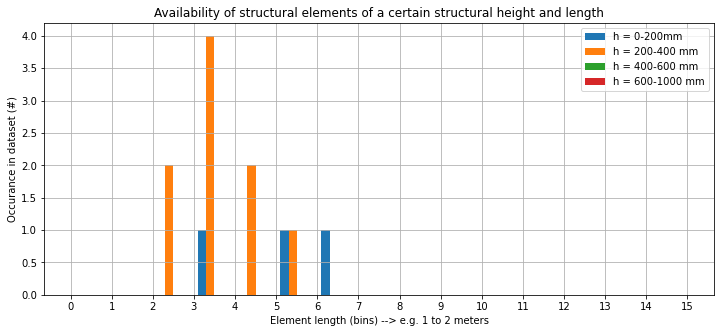

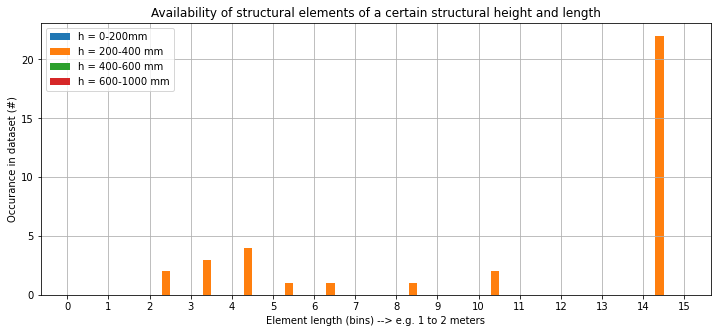

In [7]:
TheCode(1.3, 3, "ontwerp2", 50, 50)